In [1]:
!pip install lazypredict

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


## Importing libraries

In [3]:
# Data Manipulation and Analysis
import numpy as np 
import pandas as pd 

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Tabulate
from tabulate import tabulate

# Feature Selection
from sklearn.feature_selection import mutual_info_classif


# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# Transformers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Preprocessors
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, OneHotEncoder, LabelEncoder

# Automated Model Selection
from lazypredict.Supervised import LazyClassifier

# Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

# Cross validation
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict, StratifiedKFold, KFold
from sklearn.model_selection import train_test_split

# Statistical Analysis
from scipy.stats import chi2_contingency

# Metrices
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import log_loss


# Hyperparameter Tuning
import optuna

# Warnings
import warnings

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## Importing files

In [4]:
# import the obesity dataset csv files
train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

In [5]:
# Create copies of the train and test DataFrames
df_obesity_train = train.copy()
df_obesity_test = test.copy()

In [6]:
# Drop 'id' and 'CustomerId' from both training and testing dataset
df_obesity_train.drop(['id'], axis=1, inplace=True)
df_obesity_test.drop(['id'], axis=1, inplace=True)

In [7]:
df_obesity_train.rename(columns={"family_history_with_overweight": "FHWO"}, inplace=True)
df_obesity_test.rename(columns={"family_history_with_overweight": "FHWO"}, inplace=True)

In [8]:
df_obesity_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      20758 non-null  object 
 1   Age         20758 non-null  float64
 2   Height      20758 non-null  float64
 3   Weight      20758 non-null  float64
 4   FHWO        20758 non-null  object 
 5   FAVC        20758 non-null  object 
 6   FCVC        20758 non-null  float64
 7   NCP         20758 non-null  float64
 8   CAEC        20758 non-null  object 
 9   SMOKE       20758 non-null  object 
 10  CH2O        20758 non-null  float64
 11  SCC         20758 non-null  object 
 12  FAF         20758 non-null  float64
 13  TUE         20758 non-null  float64
 14  CALC        20758 non-null  object 
 15  MTRANS      20758 non-null  object 
 16  NObeyesdad  20758 non-null  object 
dtypes: float64(8), object(9)
memory usage: 2.7+ MB


In [9]:
data = [
    ["FAVC", "Frequency of consumption of high-caloric food"],
    ["FCVC", "Frequency of consumption of vegetables"],
    ["NCP", "Number of main meals"],
    ["CAEC", "Consumption of food between meals"],
    ["SMOKE", "Smoking habit"],
    ["CH2O", "Daily water consumption"],
    ["SCC", "Calories consumption monitoring"],
    ["FAF", "Physical activity frequency"],
    ["TUE", "Time spent on sedentary activities (TV/Computer)"],
    ["CALC", "Consumption of alcohol"],
    ["MTRANS", "Mode of transportation used"],
    ["FHWO", "Family history withoverweight"]
]

table = tabulate(data, headers=["Id","Column", "Description"], tablefmt="orgtbl", numalign="center", stralign="left", showindex=True )

In [10]:
print(table)

|  Id  | Column   | Description                                      |
|------+----------+--------------------------------------------------|
|  0   | FAVC     | Frequency of consumption of high-caloric food    |
|  1   | FCVC     | Frequency of consumption of vegetables           |
|  2   | NCP      | Number of main meals                             |
|  3   | CAEC     | Consumption of food between meals                |
|  4   | SMOKE    | Smoking habit                                    |
|  5   | CH2O     | Daily water consumption                          |
|  6   | SCC      | Calories consumption monitoring                  |
|  7   | FAF      | Physical activity frequency                      |
|  8   | TUE      | Time spent on sedentary activities (TV/Computer) |
|  9   | CALC     | Consumption of alcohol                           |
|  10  | MTRANS   | Mode of transportation used                      |
|  11  | FHWO     | Family history withoverweight                    |


### <b>Dataset Dimensions</b>

In [11]:
# Training dataset and Testing dataset dimensions
print("Training Dataset :",df_obesity_train.shape)
print("Testing Dataset :", df_obesity_test.shape)

Training Dataset : (20758, 17)
Testing Dataset : (13840, 16)


### <b>Obesity Dataset Columns</b>

In [12]:
df_obesity_train.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'FHWO', 'FAVC', 'FCVC', 'NCP',
       'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS',
       'NObeyesdad'],
      dtype='object')

### <b>Null values</b>

In [13]:
print("Misssing values in tranning dataset :", df_obesity_train.isna().sum().sum())
print("Misssing values in testing dataset :", df_obesity_test.isna().sum().sum())

Misssing values in tranning dataset : 0
Misssing values in testing dataset : 0


### <b>Summary Statistics</b>

In [14]:
df_obesity_train.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00,20758.00,20758.00,20758.00,20758.00,20758.00,20758.00,20758.00
mean,23.84,1.70,87.89,2.45,2.76,2.03,0.98,0.62
std,5.69,0.09,26.38,0.53,0.71,0.61,0.84,0.60
min,14.00,1.45,39.00,1.00,1.00,1.00,0.00,0.00
25%,20.00,1.63,66.00,2.00,3.00,1.79,0.01,0.00
50%,22.82,1.70,84.06,2.39,3.00,2.00,1.00,0.57
75%,26.00,1.76,111.60,3.00,3.00,2.55,1.59,1.00
max,61.00,1.98,165.06,3.00,4.00,3.00,3.00,2.00


In [15]:
df_obesity_train.nunique()

Gender           2
Age           1703
Height        1833
Weight        1979
FHWO             2
FAVC             2
FCVC           934
NCP            689
CAEC             4
SMOKE            2
CH2O          1506
SCC              2
FAF           1360
TUE           1297
CALC             3
MTRANS           5
NObeyesdad       7
dtype: int64

In [16]:
df_obesity_test.nunique()

Gender       2
Age       1539
Height    1739
Weight    1798
FHWO         2
FAVC         2
FCVC       828
NCP        649
CAEC         4
SMOKE        2
CH2O      1366
SCC          2
FAF       1260
TUE       1172
CALC         4
MTRANS       5
dtype: int64

In [17]:
df_obesity_train['NObeyesdad'].value_counts()

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

In [18]:
df_obesity_train['NObeyesdad'].value_counts(normalize=True)

NObeyesdad
Obesity_Type_III      0.19
Obesity_Type_II       0.16
Normal_Weight         0.15
Obesity_Type_I        0.14
Insufficient_Weight   0.12
Overweight_Level_II   0.12
Overweight_Level_I    0.12
Name: proportion, dtype: float64

<Axes: xlabel='NObeyesdad', ylabel='count'>

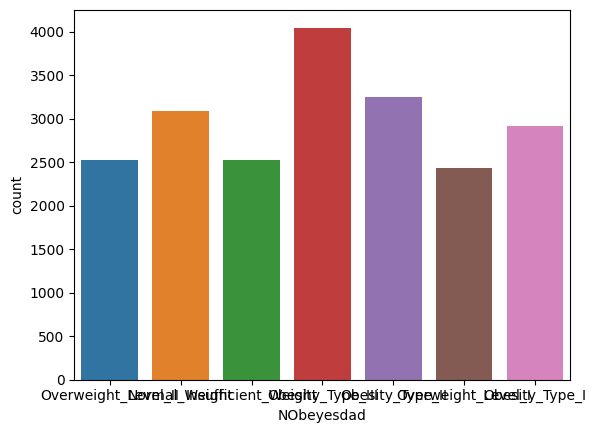

In [19]:
sns.countplot(data=df_obesity_train,x='NObeyesdad')

In [20]:
total_count = len(df_obesity_train)
total_count

20758

### <b>Numerical Columns</b>

In [21]:
obesity_numerical_features = list(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'])
obesity_numerical_features

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

### <b>Categorical Columns</b>

In [22]:
obesity_categorical_features = list(set(df_obesity_train.columns) - set(obesity_numerical_features))
obesity_categorical_features

['FHWO',
 'CALC',
 'NObeyesdad',
 'FAVC',
 'SMOKE',
 'SCC',
 'CAEC',
 'Gender',
 'MTRANS']

### <b>Numerical Feature Distribution</b>

In [ ]:
figure, axs = plt.subplots(4, 2, figsize=(20,17))

for col, ax in zip(obesity_numerical_features, axs.ravel()):
    sns.histplot(data=df_obesity_train, x=col, hue="NObeyesdad", multiple="stack", kde =True, bins=60, shrink=0.9,ax=ax)
    ax.set_title(f'Distribution for {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
     
plt.tight_layout()
plt.suptitle("Obesity Numerical Feature Distribution")
plt.show()

### <b>Categorical Feature Distribution</b>

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(17, 17))

for col, ax in zip(obesity_categorical_features, axs.ravel()):
    data_counts = df_obesity_train.groupby([col, 'NObeyesdad']).size().unstack(fill_value=0)
    data_counts.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(f'Distribution for {col}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.suptitle("Obesity Categorical Feature Distribution by NObeyesdad")
plt.show()

### <b>MI Score</b>

In [ ]:
mi_df = df_obesity_train.drop(columns=["NObeyesdad"]).copy()
mi_y = df_obesity_train['NObeyesdad'].copy()

In [ ]:
def encding_numeric_categoric(dataframe):
    if 'NObeyesdad' in dataframe.columns:
        dataframe = dataframe.drop(columns=["NObeyesdad"])
        
    # Select numerical and categorical features
    numerical_features = dataframe.select_dtypes(include=[np.number])    
    categorical_features = dataframe.select_dtypes(include=['object', 'category'])
    
    # Fill missing values in numerical features with the median
    for col in numerical_features:
        dataframe[col].fillna(dataframe[col].median(), inplace=True)
    
    # Encode categorical features as numerical using factorization
    for col in categorical_features:
        dataframe[col], _ = dataframe[col].factorize()
    
    return dataframe

In [ ]:
def make_mi_score(X, y):
    
    # Compute MI scores for feature selection
    mi_score = mutual_info_classif(X, y, discrete_features='auto')
    
    # Create a Series to store MI scores with feature names
    mi_features = pd.Series(mi_score, name="MI Score", index=X.columns).sort_values(ascending=False)
    
    return mi_features

In [ ]:
def plot_mi_score(score):

    plt.figure(figsize=(10, 6))
    sns.barplot(x=score.values, y=score.index)

    plt.title('Mutual Information Scores')
    plt.ylabel('Features')

    plt.tight_layout()
    
    return plt.show()

In [ ]:
def process_and_mi_plot(dataframe, mi_y):
    encoded_df = encding_numeric_categoric(dataframe)
    mi_score = make_mi_score(encoded_df, mi_y)
    plot_mi_score(mi_score)

In [30]:
mi_df_encode = encding_numeric_categoric(mi_df)
mi_score = make_mi_score(mi_df_encode, mi_y)
print(f"{mi_score}")

Weight   1.37
Age      0.80
Height   0.78
CH2O     0.53
FCVC     0.50
TUE      0.50
FAF      0.45
Gender   0.26
NCP      0.22
FHWO     0.17
CAEC     0.14
CALC     0.12
MTRANS   0.07
FAVC     0.05
SCC      0.02
SMOKE    0.00
Name: MI Score, dtype: float64


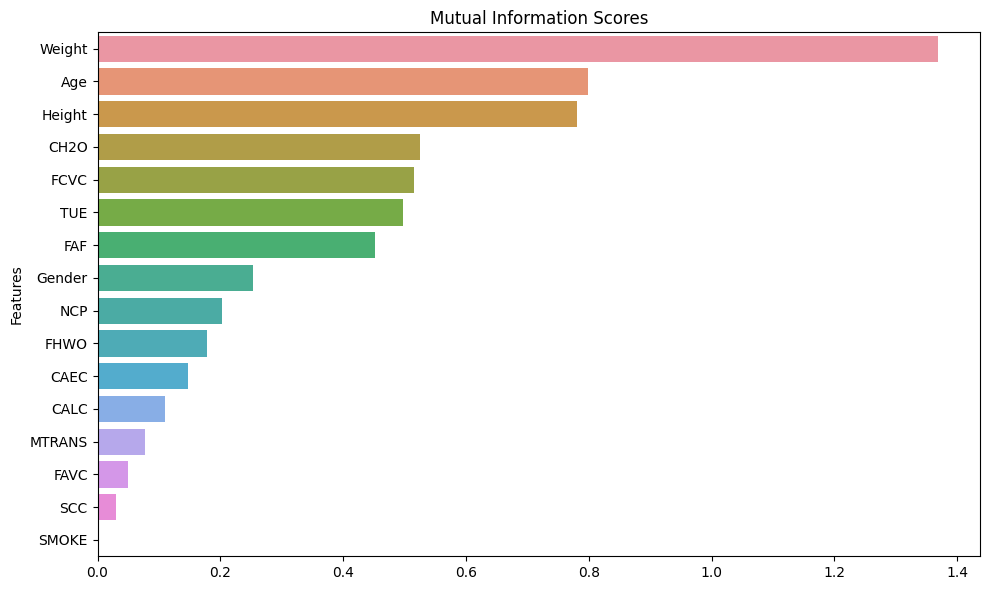

In [31]:
process_and_mi_plot(mi_df, mi_y)

### <b>Chi-square</b>

In [32]:
# Calculate the number of unique values in each column of the dataframe
value_counts = df_obesity_train.nunique()

# Extract categorical columns with more than 1 and less than 20 unique values
categorical_values = value_counts[(value_counts > 1) & (value_counts < 20)].index.tolist()

# Exclude the target variable from the list of categorical features
categorical_features_chi = list(set(categorical_values) - set(['NObeyesdad']))

In [33]:
categorical_features_chi

['FHWO', 'CALC', 'FAVC', 'SMOKE', 'SCC', 'CAEC', 'Gender', 'MTRANS']

In [34]:
# Set the significance threshold for the chi-squared test
threshold = 0.05

# Loop through each categorical feature and perform the chi-squared test
for feature in categorical_features_chi:
    # Create a contingency table for the chi-squared test
    contingency_table = pd.crosstab(df_obesity_train['NObeyesdad'], df_obesity_train[feature])
    
    # Perform the chi-squared test and extract test statistics
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    # Check if the p-value is below the significance threshold
    if p < threshold:
        # Print in green if the test passes (p-value is below the threshold)
        print(f"{feature:<28}{p:<28}Passed")
    else:
        # Print in red if the test fails (p-value is above the threshold)
        print(f"{feature:<28}{p:<28}Failed")


FHWO                        0.0                         Passed
CALC                        0.0                         Passed
FAVC                        0.0                         Passed
SMOKE                       6.396981747148422e-44       Passed
SCC                         3.870102954479357e-218      Passed
CAEC                        0.0                         Passed
Gender                      0.0                         Passed
MTRANS                      0.0                         Passed


### <b>Target mapping</b>

In [35]:
fe_df = df_obesity_train.copy()

In [36]:
fe_df['NObeyesdad'] = fe_df['NObeyesdad'].map(
    {
        'Insufficient_Weight': 0,
        'Normal_Weight': 1,
        'Overweight_Level_I': 2,
        'Overweight_Level_II': 3,
        'Obesity_Type_I': 4,
        'Obesity_Type_II': 5,
        'Obesity_Type_III': 6, 
    }
)

## Transformation of columns using Pipeline

In [37]:
# Get numerical columns from the DataFrame fe_df
original_numerical_cols = list(fe_df.select_dtypes(include=['int64', 'float64']).columns)

# Exclude unnecessary column 'NObeyesdad'
original_numerical_cols = list(set(original_numerical_cols).difference(['NObeyesdad']))

# Additional numerical features from the pipeline (currently empty, as named_preprocess_pipeline didn't create new features)
numerical_features_from_pipeline = []

# Combine original and pipeline numerical features
numerical_features = original_numerical_cols + numerical_features_from_pipeline

## Quantile Transformer

In [38]:
numerical_transformer = Pipeline(steps=[
    ('quantile', QuantileTransformer(output_distribution='normal')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
       ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [39]:
original_categorical_cols = list(fe_df.select_dtypes(include=['object']).columns)

categorical_features_from_pipeline = []
categorical_features = original_categorical_cols + categorical_features_from_pipeline

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

In [41]:
transformed_data = preprocessor.fit_transform(fe_df.drop(['NObeyesdad'], axis=1))

In [42]:
transformed_columns = preprocessor.named_transformers_['num'].get_feature_names_out().tolist() + \
                       preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(original_categorical_cols).tolist()
transformed_columns

['FCVC',
 'TUE',
 'FAF',
 'Height',
 'Age',
 'Weight',
 'CH2O',
 'NCP',
 'Gender_Female',
 'Gender_Male',
 'FHWO_no',
 'FHWO_yes',
 'FAVC_no',
 'FAVC_yes',
 'CAEC_Always',
 'CAEC_Frequently',
 'CAEC_Sometimes',
 'CAEC_no',
 'SMOKE_no',
 'SMOKE_yes',
 'SCC_no',
 'SCC_yes',
 'CALC_Frequently',
 'CALC_Sometimes',
 'CALC_no',
 'MTRANS_Automobile',
 'MTRANS_Bike',
 'MTRANS_Motorbike',
 'MTRANS_Public_Transportation',
 'MTRANS_Walking']

In [43]:
transformed_df = pd.DataFrame(transformed_data, columns=transformed_columns)
transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FCVC                          20758 non-null  float64
 1   TUE                           20758 non-null  float64
 2   FAF                           20758 non-null  float64
 3   Height                        20758 non-null  float64
 4   Age                           20758 non-null  float64
 5   Weight                        20758 non-null  float64
 6   CH2O                          20758 non-null  float64
 7   NCP                           20758 non-null  float64
 8   Gender_Female                 20758 non-null  float64
 9   Gender_Male                   20758 non-null  float64
 10  FHWO_no                       20758 non-null  float64
 11  FHWO_yes                      20758 non-null  float64
 12  FAVC_no                       20758 non-null  float64
 13  F

In [44]:
X = transformed_data
y = fe_df['NObeyesdad'].to_numpy()

In [45]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
y

array([3, 1, 0, ..., 5, 3, 5])

## Testing data on Sklearn classification class

In [47]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X,y)

LogisticRegression()

## Lazy Classsifier to understand best algorithms

In [48]:
clf = LazyClassifier(verbose=-1, ignore_warnings=True, custom_metric=None)
model, predictions = clf.fit(X_train, X_validation, y_train, y_validation)

selected_models = model[model['F1 Score'] > 0.7]
selected_models

 97%|█████████▋| 28/29 [02:24<00:02,  2.87s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1910
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 30
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574


100%|██████████| 29/29 [02:26<00:00,  5.05s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.90,0.89,None,0.90,1.88
XGBClassifier,0.90,0.89,None,0.90,1.80
RandomForestClassifier,0.89,0.88,None,0.89,2.25
BaggingClassifier,0.88,0.87,None,0.88,0.83
LogisticRegression,0.86,0.85,None,0.86,0.82
DecisionTreeClassifier,0.85,0.83,None,0.85,0.15
ExtraTreesClassifier,0.85,0.83,None,0.85,1.99
SVC,0.84,0.82,None,0.84,10.53
LinearDiscriminantAnalysis,0.78,0.76,None,0.78,0.15


In [49]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6])

## Logisitic regression

In [50]:
%%time
def objective_logistic(trial):
    param = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'C': trial.suggest_float('C', 0.1, 10),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'random_state': 42
    }
    
    stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    lr_model = LogisticRegression(**param)
    
    accuracies = []

    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lr_model.fit(X_train, y_train)
        y_prob = lr_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_prob)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

tpesampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler=tpesampler, pruner=pruner)
    study.optimize(objective_logistic, n_trials=10, n_jobs=-1, show_progress_bar=True)
    
    best_params = study.best_params
    LR_best_mean_accuracy = study.best_value
    
    LR_best = best_params
    
    print(f"\nBest Parameters: {LR_best}")
    print(f"Best Mean Accuracy: {LR_best_mean_accuracy}\n")


[I 2024-03-26 17:39:45,076] A new study created in memory with name: no-name-2ffcf425-bbb5-4dd2-a6f4-59c0c5314730


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-03-26 17:41:04,871] Trial 1 finished with value: 0.8625104115885508 and parameters: {'penalty': 'l2', 'C': 9.013594125885417, 'solver': 'saga', 'max_iter': 850}. Best is trial 1 with value: 0.8625104115885508.
[I 2024-03-26 17:41:20,895] Trial 3 finished with value: 0.7540700838034218 and parameters: {'penalty': 'l1', 'C': 7.914964102587393, 'solver': 'liblinear', 'max_iter': 312}. Best is trial 1 with value: 0.8625104115885508.
[I 2024-03-26 17:41:21,620] Trial 0 finished with value: 0.7540700838034218 and parameters: {'penalty': 'l1', 'C': 9.455476989826066, 'solver': 'liblinear', 'max_iter': 440}. Best is trial 1 with value: 0.8625104115885508.
[I 2024-03-26 17:42:18,136] Trial 6 finished with value: 0.8614505652668477 and parameters: {'penalty': 'l2', 'C': 3.8882579192417603, 'solver': 'saga', 'max_iter': 830}. Best is trial 1 with value: 0.8625104115885508.
[I 2024-03-26 17:42:54,804] Trial 4 finished with value: 0.753973860760963 and parameters: {'penalty': 'l1', 'C': 0.8

In [51]:
LR = LogisticRegression(**LR_best)

## Random Forest

In [52]:
%%time
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42
    }

    stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    rf_model = RandomForestClassifier(**param)

    accuracies = []

    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        rf_model.fit(X_train, y_train)
        y_prob = rf_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_prob)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

tpesampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler=tpesampler, pruner=pruner)
    study.optimize(objective_rf, n_trials=10, n_jobs=-1, show_progress_bar=True)

    best_params = study.best_params
    RF_best_mean_accuracy = study.best_value

    RF_best = best_params

    print(f"\nBest Parameters: {RF_best}")
    print(f"Best Mean Accuracy: {RF_best_mean_accuracy}\n")

[I 2024-03-26 17:44:29,032] A new study created in memory with name: no-name-e0563cb9-c544-4518-bf44-0f2ee538db30


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-03-26 17:44:41,535] Trial 2 finished with value: 0.8762401513568726 and parameters: {'n_estimators': 58, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 0.1433352422684887, 'bootstrap': True}. Best is trial 2 with value: 0.8762401513568726.
[I 2024-03-26 17:45:00,412] Trial 3 finished with value: 0.8910778373610047 and parameters: {'n_estimators': 81, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 0.19169577001136856, 'bootstrap': False}. Best is trial 3 with value: 0.8910778373610047.
[I 2024-03-26 17:45:50,146] Trial 4 finished with value: 0.8977255379901108 and parameters: {'n_estimators': 174, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 0.39713602704427453, 'bootstrap': True}. Best is trial 4 with value: 0.8977255379901108.
[I 2024-03-26 17:46:02,400] Trial 6 finished with value: 0.8623665064883813 and parameters: {'n_estimators': 65, 'max_depth': 15, 'min_samples_split': 

In [53]:
RF = RandomForestClassifier(**RF_best)

## LightGBM

In [54]:
%%time
def objective_lgbm(trial):
    # Define the hyperparameters to be optimized using Optuna
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200), 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 0, 4),
        'objective': 'multiclass',
        'grow_policy' : trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'num_class': 7,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'is_unbalance': True,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'device': 'gpu',
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'verbose': -1,
        'device':'gpu',
    }
    
    # Define stratified k-fold cross-validation
    stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    # Create an LGBMClassifier with the current set of hyperparameters
    lgbm_model = LGBMClassifier(**param)
    
    # Initialize list to store accuracy
    accuracies = []

    # Perform cross-validation
    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model and predict
        lgbm_model.fit(X_train, y_train)
        y_prob = lgbm_model.predict(X_test)
        
        # Calculate accuracy for the current fold
        accuracy = accuracy_score(y_test, y_prob)
        accuracies.append(accuracy)
        
    # Calculate mean accuracy over all folds  
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Initialize the TPESampler and MedianPruner for Optuna
tpesampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

if __name__ == "__main__":
    # Create an Optuna study for optimization
    study = optuna.create_study(direction='maximize', sampler=tpesampler, pruner=pruner)
    
    # Optimize the objective function using multiple trials and parallel processing
    study.optimize(objective_lgbm, n_trials=10, n_jobs=-1, show_progress_bar=True)
    
    # Retrieve the best parameters and mean accuracy
    best_params = study.best_params
    LGBM_best_mean_accuracy = study.best_value
    
    # Assign the best parameters to a variable
    LGBM_best = best_params
    
    # Print the best parameters and mean accuracy
    print(f"\n Best Parameters: {LGBM_best}")
    print(f"Best Mean Accuracy: {LGBM_best_mean_accuracy}\n")

[I 2024-03-26 17:48:16,157] A new study created in memory with name: no-name-b6cfd1cf-58e6-4835-bb6d-e8fb22b34ea2


  0%|          | 0/10 [00:00<?, ?it/s]

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning gen

[I 2024-03-26 17:48:51,054] Trial 3 finished with value: 0.8464687188058593 and parameters: {'n_estimators': 154, 'learning_rate': 0.06065615697113651, 'max_depth': 1, 'grow_policy': 'depthwise', 'min_child_weight': 4, 'reg_lambda': 0.36291305734335, 'reg_alpha': 0.1424254960980511, 'subsample': 0.4276137253032686, 'colsample_bytree': 0.8695658965239631}. Best is trial 3 with value: 0.8464687188058593.
[I 2024-03-26 17:48:57,574] Trial 0 finished with value: 0.8233452190263947 and parameters: {'n_estimators': 165, 'learning_rate': 0.07665674653567756, 'max_depth': 1, 'grow_policy': 'lossguide', 'min_child_weight': 6, 'reg_lambda': 0.6361432488661134, 'reg_alpha': 0.593494533304022, 'subsample': 0.22110311396120289, 'colsample_bytree': 0.18681570337621767}. Best is trial 3 with value: 0.8464687188058593.
[I 2024-03-26 17:49:11,398] Trial 2 finished with value: 0.9002310281588783 and parameters: {'n_estimators': 171, 'learning_rate': 0.08770920757413733, 'max_depth': 2, 'grow_policy': 'l

In [55]:
LGBM = LGBMClassifier(**LGBM_best, verbosity=-1)

## XGBoost

In [56]:
%%time
def objective_xgb(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 0, 4),
        'objective': 'multi:softmax',
        'grow_policy' : trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'num_class': 7,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        'random_state': 42,
        'lambda': trial.suggest_float('reg_lambda', 0, 1),
        'alpha': trial.suggest_float('reg_alpha', 0, 1),
        'booster': 'gbtree',
        'device': 'cuda',
        'verbosity': 1,
        'device': 'gpu'
}
    
    stratified_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    xgb_model = XGBClassifier(**param)
    
    accuracies = []

    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        xgb_model.fit(X_train, y_train)
        y_prob = xgb_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_prob)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

tpesampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)

if __name__ == "__main__":
    study = optuna.create_study(direction='maximize', sampler=tpesampler, pruner=pruner)
    study.optimize(objective_xgb, n_trials=10, n_jobs=-1, show_progress_bar=True)
    
    best_params = study.best_params
    XGB_best_mean_accuracy = study.best_value
    
    XGB_best = best_params
    
    print(f"\nBest Parameters: {XGB_best}")
    print(f"Best Mean Accuracy:{XGB_best_mean_accuracy}\n")

[I 2024-03-26 17:50:09,635] A new study created in memory with name: no-name-df8aceea-9a8a-4a14-9248-569bac8a2792


  0%|          | 0/10 [00:00<?, ?it/s]

[17:50:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



[I 2024-03-26 17:50:37,073] Trial 1 finished with value: 0.8095673329154769 and parameters: {'n_estimators': 107, 'learning_rate': 0.02533604080841367, 'max_depth': 2, 'grow_policy': 'depthwise', 'min_child_weight': 1, 'subsample': 0.8164903453649608, 'colsample_bytree': 0.8312177731992902, 'gamma': 0.9624204149843993, 'reg_lambda': 0.11042293217851207, 'reg_alpha': 0.3499804743365308}. Best is trial 1 with value: 0.8095673329154769.
[I 2024-03-26 17:50:39,219] Trial 2 finished with value: 0.817275599507858 and parameters: {'n_estimators': 159, 'learning_rate': 0.06421116482606504, 'max_depth': 1, 'grow_policy': 'depthwise', 'min_child_weight': 4, 'subsample': 0.3618147188913947, 'colsample_bytree': 0.8456657830963847, 'gamma': 0.18784674394631182, 'reg_lambda': 0.07842921742918207, 'reg_alpha': 0.7541256454686478}. Best is trial 2 with value: 0.817275599507858.
[I 2024-03-26 17:50:45,425] Trial 0 finished with value: 0.8816360006499988 and parameters: {'n_estimators': 96, 'learning_ra

In [57]:
XGB = XGBClassifier(**XGB_best)

## Cross Validation

In [58]:
def accuracy_metrics(model, name):
    # Define stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    print(f'-----{name}-----', end="\n\n")

    # Initialize lists to store accuracy
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Iterate over the folds
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model on the training data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics for evaluation
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Print metrics for each fold
        print(f'Fold {fold + 1}, Accuracy: {accuracy}')
        print(f'Fold {fold + 1}, Precision: {precision}')
        print(f'Fold {fold + 1}, Recall: {recall}')
        print(f'Fold {fold + 1}, F1 Score: {f1}', end="\n\n")

    # Compute mean and standard deviation for each metric
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    mean_precision = np.mean(precisions)
    std_precision = np.std(precisions)

    mean_recall = np.mean(recalls)
    std_recall = np.std(recalls)

    mean_f1_score = np.mean(f1_scores)
    std_f1_score = np.std(f1_scores)

    # Print mean and standard deviation for each metric
    print(f'\n{name} With Stratified Cross-Validation Accuracy (Mean): {mean_accuracy:.6f}')
    print(f'{name} With Stratified Cross-Validation Accuracy (Standard deviation): {std_accuracy:.6f}',  end="\n\n")
    
    print(f'{name} With Stratified Cross-Validation Precision (Mean): {mean_precision:.6f}')
    print(f'{name} With Stratified Cross-Validation Precision (Standard deviation): {std_precision:.6f}',  end="\n\n")

    print(f'{name} With Stratified Cross-Validation Recall (Mean): {mean_recall:.6f}')
    print(f'{name} With Stratified Cross-Validation Recall (Standard deviation): {std_recall:.6f}',  end="\n\n")

    print(f'{name} With Stratified Cross-Validation F1 Score (Mean): {mean_f1_score:.6f}')
    print(f'{name} With Stratified Cross-Validation F1 Score (Standard deviation): {std_f1_score:.6f}', end="\n\n\n\n")

In [59]:
accuracy_metrics(LR, 'LR')
accuracy_metrics(RF, 'RF')
accuracy_metrics(XGB, 'XGB')
accuracy_metrics(LGBM, 'LGBM')

-----LR-----

Fold 1, Accuracy: 0.8624277456647399
Fold 1, Precision: 0.8614684156881118
Fold 1, Recall: 0.8624277456647399
Fold 1, F1 Score: 0.8616072616201493

Fold 2, Accuracy: 0.8713686948981066
Fold 2, Precision: 0.8707412384567921
Fold 2, Recall: 0.8713686948981066
Fold 2, F1 Score: 0.8706888712228854

Fold 3, Accuracy: 0.8570602688249747
Fold 3, Precision: 0.8559410247831974
Fold 3, Recall: 0.8570602688249747
Fold 3, F1 Score: 0.856354822489181


LR With Stratified Cross-Validation Accuracy (Mean): 0.863619
LR With Stratified Cross-Validation Accuracy (Standard deviation): 0.005902

LR With Stratified Cross-Validation Precision (Mean): 0.862717
LR With Stratified Cross-Validation Precision (Standard deviation): 0.006106

LR With Stratified Cross-Validation Recall (Mean): 0.863619
LR With Stratified Cross-Validation Recall (Standard deviation): 0.005902

LR With Stratified Cross-Validation F1 Score (Mean): 0.862884
LR With Stratified Cross-Validation F1 Score (Standard deviation)

In [60]:
XGB.feature_importances_

array([0.10221905, 0.0284243 , 0.01447537, 0.02791011, 0.03461976,
       0.13364016, 0.02569197, 0.01765126, 0.08901214, 0.16360085,
       0.03385904, 0.03344066, 0.02248037, 0.02510776, 0.01300246,
       0.04651333, 0.02558426, 0.03570927, 0.0014715 , 0.00083332,
       0.00878008, 0.01253986, 0.01156104, 0.01897858, 0.03124907,
       0.01807844, 0.00077379, 0.00137123, 0.01894468, 0.00247629],
      dtype=float32)

## Feature Importance

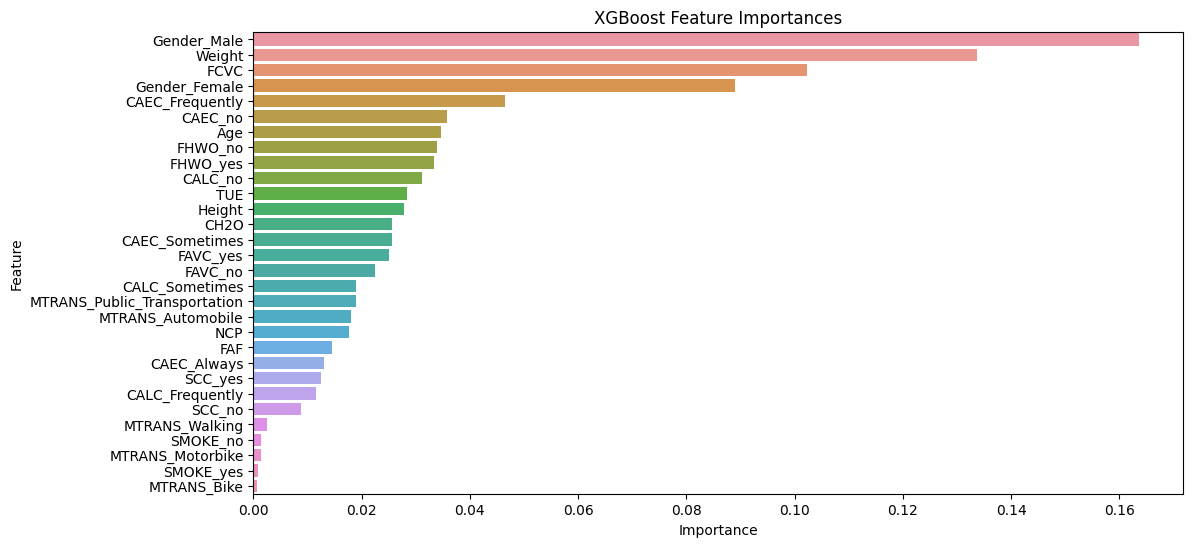

In [61]:
feature_importance_df = pd.DataFrame(
    {'Feature': transformed_df.columns, 'Importance': XGB.feature_importances_}
)

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importances')
plt.show()

## Voting Classifier

In [62]:
%%time
def objective(trial):
    # Define stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize list to store accuracy
    accuracies = []
    
    # Define hyperparameters to be optimized
    xgb_weight = trial.suggest_float('xgb_weight', 0.0, 1.0)
    rf_weight = trial.suggest_float('rf_weight', 0.0, 1.0)
    lgbm_weight = trial.suggest_float('lbgm_weight', 0.0, 1.0)
    lr_weight = trial.suggest_float('lr_weight', 0.0, 1.0)
    voting = trial.suggest_categorical(
            "voting", ["hard", "soft"]
        ),

    # Create a VotingClassifier with specified hyperparameters
    voting_classifier = VotingClassifier(
        estimators=[
            ('xgb', XGB),
            ('rf', RF),
            ('lgbm', LGBM),
            ('lr',LR)
            
        ],
        n_jobs=-1,
#         voting='hard',
        weights=[xgb_weight, rf_weight, lgbm_weight,lr_weight]
    )
    
    # Iterate over the folds
    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the VotingClassifier on the training data
        voting_classifier.fit(X_train, y_train)
        y_pred = voting_classifier.predict(X_test)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
    # Calculate mean accuracy over all folds
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    
    return mean_accuracy

# Set up Optuna sampler and pruner
tpesampler = optuna.samplers.TPESampler(seed=42)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=2)

if __name__ == "__main__":
    # Create an Optuna study for hyperparameter optimization
    study = optuna.create_study(direction='maximize', sampler=tpesampler, pruner=pruner)
    
    # Optimize the objective function (maximize mean accuracy)
    study.optimize(objective, n_trials=5, n_jobs=-1, show_progress_bar=True)
    
    # Retrieve the best weights and the mean accuracy
    best_params = study.best_params
    best_xgb_weight = best_params['xgb_weight']
    best_rf_weight = best_params['rf_weight']
    best_lgbm_weight = best_params['lbgm_weight']
    best_lr_weight = best_params['lr_weight']
    best_voter = best_params['voting']
    
    voting_best_mean_accuracy = study.best_value

    # Print the best weights and the mean accuracy
    print(f"\nBest Mean Accuracy:{voting_best_mean_accuracy:.6f}", end="\n\n")
    print(f"\nBest Weights:{best_params}", end="\n\n")
    print(f"Best XGB Weight:{best_xgb_weight}")    
    print(f"Best rf Weight:{best_rf_weight}")        
    print(f"Best lgbm Weight:{best_lgbm_weight}")  
    print(f"Best lr Weight:{best_lr_weight}")  
    print(f"Best voting:{best_voter}")

[I 2024-03-26 17:52:22,477] A new study created in memory with name: no-name-51f05a01-f1bf-42b9-bdb5-86e07f3c50f1


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

[I 2024-03-26 17:55:51,502] Trial 0 finished with value: 0.9036994474948349 and parameters: {'xgb_weight': 0.2647536181361184, 'rf_weight': 0.6649607672886856, 'lbgm_weight': 0.4795873711517261, 'lr_weight': 0.916943744705921, 'voting': 'soft'}. Best is trial 0 with value: 0.9036994474948349.
[I 2024-03-26 17:55:59,948] Trial 3 finished with value: 0.9065417182478953 and parameters: {'xgb_weight': 0.6216098555035723, 'rf_weight': 0.13262932312561349, 'lbgm_weight': 0.2373464646626775, 'lr_weight': 0.6516011599358171, 'voting': 'hard'}. Best is trial 3 with value: 0.9065417182478953.
[I 2024-03-26 17:56:11,718] Trial 1 finished with value: 0.9075533601718183 and parameters: {'xgb_weight': 0.6770971876595057, 'rf_weight': 0.4589078813197588, 'lbgm_weight': 0.9968484791015547, 'lr_weight': 0.6628415217295588, 'voting': 'soft'}. Best is trial 1 with value: 0.9075533601718183.
[I 2024-03-26 17:56:17,251] Trial 2 finished with value: 0.9030248880298594 and parameters: {'xgb_weight': 0.269853

In [63]:
best_params = study.best_params
best_xgb_weight = best_params['xgb_weight']
best_rf_weight = best_params['rf_weight']
best_lgbm_weight = best_params['lbgm_weight']
best_lr_weight = best_params['lr_weight']
best_voter = best_params['voting']

voting_best_mean_accuracy = study.best_value

# Print the best weights and the mean accuracy
print(f"\nBest Mean Accuracy:{voting_best_mean_accuracy:.6f}", end="\n\n")
print(f"\nBest Weights:{best_params}", end="\n\n")
print(f"Best XGB Weight:{best_xgb_weight}")    
print(f"Best rf Weight:{best_rf_weight}")        
print(f"Best lgbm Weight:{best_lgbm_weight}")  
print(f"Best lr Weight:{best_lr_weight}")  
print(f"Best voting:{best_voter}")


Best Mean Accuracy:0.907553


Best Weights:{'xgb_weight': 0.6770971876595057, 'rf_weight': 0.4589078813197588, 'lbgm_weight': 0.9968484791015547, 'lr_weight': 0.6628415217295588, 'voting': 'soft'}

Best XGB Weight:0.6770971876595057
Best rf Weight:0.4589078813197588
Best lgbm Weight:0.9968484791015547
Best lr Weight:0.6628415217295588
Best voting:soft


In [64]:
voting_classifier = VotingClassifier(
        estimators=[
            ('xgb', XGB),
            ('rf', RF),
            ('lgbm', LGBM),
            ('lr',LR)
        ],
        n_jobs=-1,
        voting=best_voter,
        weights=[best_xgb_weight, best_rf_weight, best_lgbm_weight,best_lr_weight]
    )

In [65]:
voting_classifier

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6114959851877596,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.13689562255502555,
                                            grow_policy='depthwise',
                                            importance_type=None,
                                            inte...
                                             max_depth=3, min_child_weight=6,
                                             n_estimators=176,
                                             reg_alpha=0.5973608073672094,
                                             reg_lambda=0.49427546681586054,
                                             subsample=0.22494043972969313,
                                             verbosity=-1)),
                             ('lr',
                              LogisticRegression(C=6.293428850479796,
                                                 max_iter=714, penalty='l1',
                                                 solver='saga'))],
                 n_jobs=-1, voting='soft',
                 weights=[0.6770971876595057, 0.4589078813197588,
                          0.9968484791015547, 0.6628415217295588])

In [66]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Stacked Ensembles

In [67]:
# Create the base estimators for the StackingClassifier
base_estimators = [
    ('xgb', XGB),
    ('rf', RF),
    ('lgbm', LGBM),
    ('lr', LR)
]

# Create the StackingClassifier with the specified meta-model
stacked_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(),
    n_jobs=-1,
    stack_method='auto',  # Default value is 'auto', but you can specify a different method if needed
)

In [68]:
stacked_model

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6114959851877596,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=0.13689562255502555,
                                              grow_policy='depthwise',
                                              importance_type=None,
                                              in...
                                LGBMClassifier(colsample_bytree=0.9502372328271999,
                                               grow_policy='depthwise',
                                               learning_rate=0.08137102599453173,
                                               max_depth=3, min_child_weight=6,
                                               n_estimators=176,
                                               reg_alpha=0.5973608073672094,
                                               reg_lambda=0.49427546681586054,
                                               subsample=0.22494043972969313,
                                               verbosity=-1)),
                               ('lr',
                                LogisticRegression(C=6.293428850479796,
                                                   max_iter=714, penalty='l1',
                                                   solver='saga'))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [72]:
accuracy_metrics(stacked_model, 'stacked_ensemble')

-----stacked_ensemble-----



/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


Fold 1, Accuracy: 0.9089595375722543
Fold 1, Precision: 0.9090285178907348
Fold 1, Recall: 0.9089595375722543
Fold 1, F1 Score: 0.9088461136660599

Fold 2, Accuracy: 0.9090909090909091
Fold 2, Precision: 0.9090288598043073
Fold 2, Recall: 0.9090909090909091
Fold 2, F1 Score: 0.9089021261044096



/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 3, Accuracy: 0.9020089608324903
Fold 3, Precision: 0.9017586016750965
Fold 3, Recall: 0.9020089608324903
Fold 3, F1 Score: 0.9018669326078711


stacked_ensemble With Stratified Cross-Validation Accuracy (Mean): 0.906686
stacked_ensemble With Stratified Cross-Validation Accuracy (Standard deviation): 0.003308

stacked_ensemble With Stratified Cross-Validation Precision (Mean): 0.906605
stacked_ensemble With Stratified Cross-Validation Precision (Standard deviation): 0.003427

stacked_ensemble With Stratified Cross-Validation Recall (Mean): 0.906686
stacked_ensemble With Stratified Cross-Validation Recall (Standard deviation): 0.003308

stacked_ensemble With Stratified Cross-Validation F1 Score (Mean): 0.906538
stacked_ensemble With Stratified Cross-Validation F1 Score (Standard deviation): 0.003303





## Confusion Matrix

In [69]:
def matrices(model, name, X, y, cv=skf):
    
    predicted_classifier = cross_val_predict(model, X, y, cv=cv)
    conf_matrices = confusion_matrix(y, predicted_classifier)

    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrices, annot=True, fmt='d', cmap='crest', annot_kws={'fontsize': 10}, square=True)
    
    plt.xlabel('Predicted', fontsize=10, color='black', fontweight='bold')
    plt.ylabel('Actual',  fontsize=10, color='black', fontweight='bold')
    
    plt.xticks(fontsize=10, color='black')
    plt.yticks(fontsize=10, color='black')
    
    plt.title(f'Confusion Matrix With {name} Classifier')
    
    return plt.show()

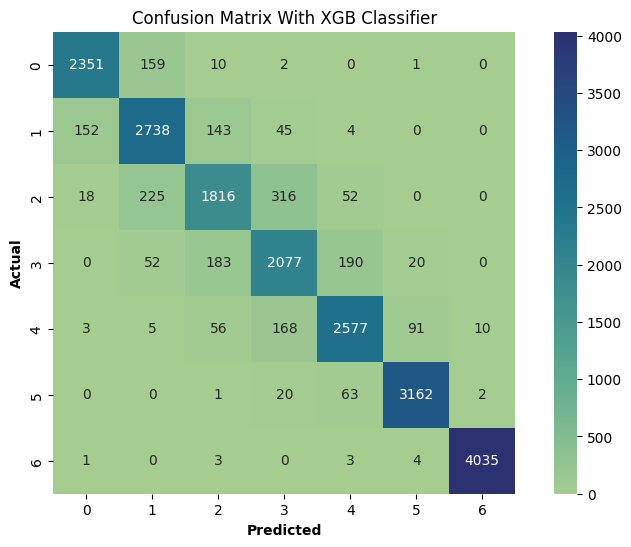

In [70]:
matrices(XGB, 'XGB', transformed_data, y)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


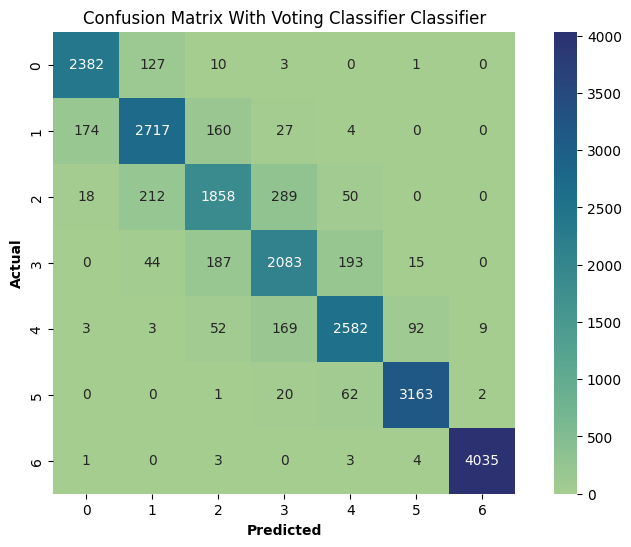

In [74]:
matrices(voting_classifier, 'Voting Classifier', transformed_data, y)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


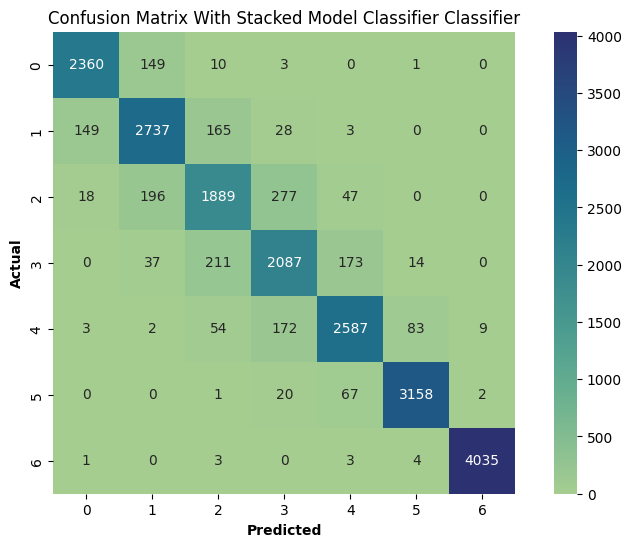

In [73]:
matrices(stacked_model, 'Stacked Model Classifier', transformed_data, y)

In [ ]:
final_pipeline=Pipeline(steps=[('preprocessor',preprocessor),('model',stacked_model)])

## Submissions

In [75]:
def submission(model, name, filename):
    df_obesity_test_transformed = preprocessor.transform(df_obesity_test)
    model.fit(X,y)
    
    y_pred_best = model.predict(df_obesity_test_transformed)
    
    df_obesity_submission = test[['id']].copy()
    df_obesity_submission['NObeyesdad'] = y_pred_best.flatten()
    
    label_mapping = {
        0 : 'Insufficient_Weight',
        1 : 'Normal_Weight',
        2 : 'Overweight_Level_I',
        3 : 'Overweight_Level_II',
        4 : 'Obesity_Type_I',
        5 : 'Obesity_Type_II',
        6 : 'Obesity_Type_III', 
    }

    df_obesity_submission['NObeyesdad'] = df_obesity_submission['NObeyesdad'].map(label_mapping)
    df_obesity_submission.to_csv(f"{filename}_submit.csv", index=False)

In [78]:
submission(voting_classifier, 'Voting Classifier', 'voting_lgbm_xgb')
submission(LGBM, 'LGBM Classifier', 'lgbm')
submission(XGB, 'XGB Classifier', 'xgb')
submission(LR, 'LR Classifier', 'lr')
submission(RF, 'RF Classifier', 'rf')
submission(stacked_model,'Stacked Ensemble Classifier','stacked_ensemble')

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
